In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
path= "../data/anime_names.txt"
with open(path , "r") as f:
    names = f.read().splitlines()

In [5]:
chars = sorted(list(set("".join(names))))

In [6]:
print("Total names: ", len(names))
print("Total chars: ", len(chars))
print("Characters: ", chars)

Total names:  72776
Total chars:  66
Characters:  ['#', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
str_to_idx = {c : i+1 for i , c in enumerate(chars)}
str_to_idx["."] = 0
idx_to_str = {i : c for c , i in str_to_idx.items()}
print(idx_to_str)

{1: '#', 2: '-', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z', 40: '_', 41: 'a', 42: 'b', 43: 'c', 44: 'd', 45: 'e', 46: 'f', 47: 'g', 48: 'h', 49: 'i', 50: 'j', 51: 'k', 52: 'l', 53: 'm', 54: 'n', 55: 'o', 56: 'p', 57: 'q', 58: 'r', 59: 's', 60: 't', 61: 'u', 62: 'v', 63: 'w', 64: 'x', 65: 'y', 66: 'z', 0: '.'}


In [ ]:
context_len = 8
def build_dataset(names):
    X , Y = [] , []
    
    for name in names:
        context = [0] * context_len
        for ch in name + ".":
            ix = str_to_idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = tf.convert_to_tensor(X)
    Y = tf.convert_to_tensor(Y)
    print("X shape: ", X.shape)
    print("Y shape: ", Y.shape)
    return X , Y

In [10]:
import random

In [11]:
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr , Ytr = build_dataset(names[:n1])
Xval , Yval = build_dataset(names[n1:n2])
Xte , Yte = build_dataset(names[n2:])

X shape:  (834485, 8)
Y shape:  (834485,)
X shape:  (104065, 8)
Y shape:  (104065,)
X shape:  (104276, 8)
Y shape:  (104276,)


In [31]:
n_emb = 128
n_neurons_l1 = 512
n_neurons_l2 = 384
n_neurons_l3 = 256
n_neurons = n_neurons_l1 + n_neurons_l2 + n_neurons_l3
vocab_size = len(idx_to_str) #67
context_len = Xtr.shape[1] #8
momentum = 0.99
dropout = 0.2

In [32]:
gamma_1 = tf.Variable(tf.ones(shape=(n_neurons_l1)))
beta_1 = tf.Variable(tf.zeros(shape=(n_neurons_l1)))

gamma_2 = tf.Variable(tf.ones(shape=(n_neurons_l2)))
beta_2 = tf.Variable(tf.zeros(shape=(n_neurons_l2)))

gamma_3 = tf.Variable(tf.ones(shape=(n_neurons_l3)))
beta_3 = tf.Variable(tf.zeros(shape=(n_neurons_l3)))

In [33]:
running_mean_01 = tf.Variable(tf.zeros([1, n_neurons_l1]), trainable=False)
running_std_01 = tf.Variable(tf.ones([1, n_neurons_l1]), trainable=False)


running_mean_02 = tf.Variable(tf.zeros([1, n_neurons_l2]), trainable=False)
running_std_02 = tf.Variable(tf.ones([1, n_neurons_l2]), trainable=False)


running_mean_03 = tf.Variable(tf.zeros([1, n_neurons_l3]), trainable=False)
running_std_03 = tf.Variable(tf.ones([1, n_neurons_l3]), trainable=False)

In [34]:
seed = tf.random.set_seed(424242424)
initializer = tf.keras.initializers.HeNormal(seed=seed)

C = tf.Variable(tf.random.uniform(shape=(vocab_size , n_emb) , seed = seed))

W1 = tf.Variable(initializer(shape=(n_emb*context_len , n_neurons_l1)))
b1 = tf.Variable(tf.random.uniform(shape=[n_neurons_l1]))

W2 = tf.Variable(initializer(shape=(n_neurons_l1 , n_neurons_l2)))
b2 = tf.Variable(tf.random.uniform(shape = [n_neurons_l2]))

W3 = tf.Variable(initializer(shape=(n_neurons_l2 , n_neurons_l3)))
b3 = tf.Variable(tf.random.uniform(shape = [n_neurons_l3]))

W4 = tf.Variable(initializer(shape=(n_neurons_l3 , vocab_size)))
b4 = tf.Variable(tf.random.uniform(shape = [vocab_size]))

In [35]:
parameters = [C , W1 , b1 , W2 , b2 , W3 , b3 , W4 , b4 , gamma_1 , beta_1 , gamma_2 , beta_2 , gamma_3 , beta_3]
no_params = 0
for p in parameters:
  no_params += tf.size(p).numpy()

print('Total number of parameters: ', no_params.item())

Total number of parameters:  848451


In [36]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [37]:
num_epochs = 5000
learning_rate = 0.001
losses = []
batch_size = 32

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(num_epochs):
    ix = tf.keras.random.randint(shape = (batch_size,) , minval=0 , maxval=Xtr.shape[0] , seed = seed)
    Xb, Yb = tf.gather(Xtr , ix) , tf.gather(Ytr , ix) # batch X,Y

    with tf.GradientTape() as tape:
        # Embedding and reshape
        emb = tf.gather(C, Xb)  # [batch, block_size, embedding_dim]
        x1 = tf.reshape(emb, shape=(-1, n_emb * context_len))

        # Layer 1 linear transformation
        x1 = x1 @ W1 + b1

        # BatchNorm1
        mean1 = tf.reduce_mean(x1, axis=0, keepdims=True)
        std1 = tf.math.reduce_std(x1, axis=0, keepdims=True)
        x1 = (x1 - mean1) / tf.sqrt(std1 + 1e-5)
        x1 = x1 * gamma_1 + beta_1

        # Activation
        h1 = tf.keras.activations.gelu(x1)

        # Layer 2
        x2 = h1 @ W2 + b2

        # BatchNorm2
        mean2 = tf.reduce_mean(x2, axis=0, keepdims=True)
        std2 = tf.math.reduce_std(x2, axis=0, keepdims=True)
        x2 = (x2 - mean2) / tf.sqrt(std2 + 1e-5)
        x2 = x2 * gamma_2 + beta_2

        # Activation
        h2 = tf.keras.activations.gelu(x2)

        # Layer 3
        x3 = h2 @ W3 + b3

        # BatchNorm 3
        mean3 = tf.reduce_mean(x3, axis=0, keepdims=True)
        std3 = tf.math.reduce_std(x3, axis=0, keepdims=True)
        x3 = (x3 - mean3) / tf.sqrt(std3 + 1e-5)
        x3 = x3 * gamma_3 + beta_3

        # Activation
        h3 = tf.keras.activations.gelu(x3)

        # Output layer
        logits = h3 @ W4 + b4

        # Loss
        loss = loss_fn(tf.reshape(Yb, [-1]), logits)

    # Update running statistics (outside the tape)
    running_mean_01.assign(momentum * running_mean_01 + (1. - momentum) * mean1)
    running_std_01.assign(momentum * running_std_01 + (1. - momentum) * std1)
    running_mean_02.assign(momentum * running_mean_02 + (1. - momentum) * mean2)
    running_std_02.assign(momentum * running_std_02 + (1. - momentum) * std2)
    running_mean_03.assign(momentum * running_mean_03 + (1. - momentum) * mean3)
    running_std_03.assign(momentum * running_std_03 + (1. - momentum) * std3)

    # Backprop
    grads = tape.gradient(loss, parameters)
    optimizer.apply_gradients(zip(grads, parameters))

    losses.append(loss.numpy())

    if epoch % 25 == 0:
        print(f"epoch={epoch}, loss={loss.numpy():.4f}")

epoch=0, loss=4.6180
epoch=25, loss=3.0484
epoch=50, loss=2.8201
epoch=75, loss=2.6422
epoch=100, loss=2.7909
epoch=125, loss=2.3445
epoch=150, loss=2.6836
epoch=175, loss=2.2144
epoch=200, loss=2.5810
epoch=225, loss=2.1503
epoch=250, loss=2.3875
epoch=275, loss=2.6087
epoch=300, loss=2.1366
epoch=325, loss=2.7393
epoch=350, loss=2.0921
epoch=375, loss=2.1945
epoch=400, loss=1.8801
epoch=425, loss=2.2145
epoch=450, loss=2.3487
epoch=475, loss=2.9805
epoch=500, loss=2.2387
epoch=525, loss=2.3285
epoch=550, loss=2.4074
epoch=575, loss=2.2729
epoch=600, loss=2.1736
epoch=625, loss=1.9213
epoch=650, loss=2.2843
epoch=675, loss=1.8874
epoch=700, loss=1.8810
epoch=725, loss=2.3484
epoch=750, loss=2.5088
epoch=775, loss=1.5607
epoch=800, loss=2.0998
epoch=825, loss=1.8601
epoch=850, loss=1.6415
epoch=875, loss=1.9140
epoch=900, loss=1.9353
epoch=925, loss=2.4217
epoch=950, loss=2.2955
epoch=975, loss=2.2604
epoch=1000, loss=2.2309
epoch=1025, loss=1.9522
epoch=1050, loss=2.0275
epoch=1075, l

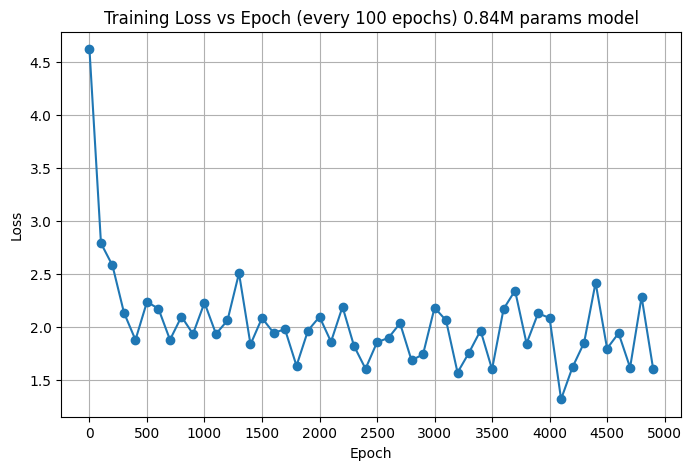

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(range(0, num_epochs, 100), [losses[i] for i in range(0, num_epochs, 100)], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch (every 100 epochs) 0.84M params model')
plt.xticks(np.arange(0, num_epochs+1, 500))
plt.grid(True)
plt.show()

In [46]:
print("Traning loss: ",losses[-1].item())

Traning loss:  1.8920989036560059


In [47]:
emb = tf.gather(C,Xval) # [batch, block_size, embedding_dim]
x1 = tf.reshape(emb, shape=(-1, n_emb * context_len))
x1 = x1 @ W1 + b1
x1 = (x1 - running_mean_01) / tf.sqrt(running_std_01 + 1e-5)
x1 = x1 * gamma_1 + beta_1
h1 = tf.keras.activations.gelu(x1)

x2 = h1 @ W2 + b2
x2 = (x2 - running_mean_02) / tf.sqrt(running_std_02 + 1e-5)
x2 = x2 * gamma_2 + beta_2
h2 = tf.keras.activations.gelu(x2)

x3 = h2 @ W3 + b3
x3 = (x3 - running_mean_03) / tf.sqrt(running_std_03 + 1e-5)
x3 = x3 * gamma_3 + beta_3
h3 = tf.keras.activations.gelu(x3)

logits = h3 @ W4 + b4
loss = loss_fn(tf.reshape(Yval, [-1]), logits)
print("Validation loss: ",loss.numpy().item())

Validation loss:  1.8731571435928345


In [56]:

checkpoint = tf.train.Checkpoint(
    C = C , W1 = W1 , b1 = b1 , W2 = W2 , b2 = b2 , W3 = W3 , b3 = b3 , W4 = W4 , b4 = b4 , gamma_1 = gamma_1 , beta_1 = beta_1 , gamma_2 = gamma_2 , beta_2 = beta_2 , gamma_3 = gamma_3 , beta_3 = beta_3 ,
    running_mean_01 = running_mean_01 , running_std_01 = running_std_01 , running_mean_02 = running_mean_02 , running_std_02 = running_std_02 , running_mean_03 = running_mean_03 , running_std_03 = running_std_03 ,
    
)

save_path = checkpoint.save("../checkpoints/checkpoints_84/anime_names")
print(f"Model saved at: {save_path}")

Model saved at: ../checkpoints/checkpoints_84/anime_names-1


In [59]:
def generate_names(num_names=10, temperature=1.0, top_k=None):
    
    generated_names = []
    block_size = 8  # Same as training context length
    
    for _ in range(num_names):
        out = []
        context = [0] * block_size  # Initialize with padding
        
        while True:
            # Get embeddings for current context
            emb = tf.gather(C , tf.constant([context] , dtype=tf.int32)) 
            x1 = tf.reshape(emb, shape=(-1, n_emb * block_size))
            x1 = x1 @ W1 + b1
            x1 = (x1 - running_mean_01) / tf.sqrt(running_std_01 + 1e-5)
            x1 = x1 * gamma_1 + beta_1
            h1 = tf.keras.activations.gelu(x1)
            x2 = h1 @ W2 + b2
            x2 = (x2 - running_mean_02) / tf.sqrt(running_std_02 + 1e-5)
            x2 = x2 * gamma_2 + beta_2
            h2 = tf.keras.activations.gelu(x2)
            x3 = h2 @ W3 + b3
            x3 = (x3 - running_mean_03) / tf.sqrt(running_std_03 + 1e-5)
            x3 = x3 * gamma_3 + beta_3
            h3 = tf.keras.activations.gelu(x3)
            logits = tf.matmul(h3, W4) + b4 
            
            # Apply temperature
            logits = logits / temperature
            
            # Optional top-k sampling
            if top_k is not None:
                v, _ = tf.nn.top_k(logits, k=top_k)
                min_value = v[:, -1:]
                logits = tf.where(logits < min_value, 
                                tf.ones_like(logits) * -1e10, 
                                logits)
            
            # Get probabilities and sample
            probs = tf.nn.softmax(logits, axis=1)
            ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
            
            # Update context and output
            context = context[1:] + [ix]
            out.append(ix)
            
            # Break if we hit the end token (0) or name gets too long
            if ix == 0 or len(out) > 40:
                break
        
        name = ''.join(idx_to_str[i] for i in out).replace('.', '')
        generated_names.append(name)
    
    return generated_names

# Generate some example names with different settings
print("Default sampling:")
names = generate_names(num_names=5)
for name in names:
    print(f"- {name}")

print("\nMore creative sampling (higher temperature):")
names = generate_names(num_names=5, temperature=1.2)
for name in names:
    print(f"- {name}")

print("\nMore focused sampling (with top-k):")
names = generate_names(num_names=5, temperature=0.8, top_k=10)
for name in names:
    print(f"- {name}")

Default sampling:
- Touko_Kozenjou_Fujiya
- Sayoyu_Eishizushibo
- Ryouo_Shilattiniha
- Angeri_Volf
- Arsus_Chigasa

More creative sampling (higher temperature):
- Clangersha_Nowagura
- Inua__Harmar
- Yu_Geotsu
- Taena_Tomouda
- Marnka_Saekami

More focused sampling (with top-k):
- Youta_Shiroujou
- Yuki_Hiyaki
- Yuuya_Sourta
- Kirone_Makishima
- Aya_Kyouda


In [ ]:
# df = pd.DataFrame(names, columns=["Generated_Name"])
# df.to_csv("../samples/generated_names.csv", index=False)